##  Прогнозирование временных рядов

## Постановка задачи

**Прогнозирование** - оценка будущих значений ряда на основе его прошлого

Горизонт прогнозирования (`H`). `H` - на сколько шагов вперёд нужен прогноз (например, 7 дней). Чем больше `H`, тем выше неопределённость

Одношаговый или многошаговый прогноз - предсказываем следующий шаг (`t +1`) или сразу несколько (`t+1`, ... `t+H`).

Форма прогноза: предсказательный интервал или точечные реализации

Стоит посмотреть: [Data Mining in Action Лекция 10 Прогнозирование временных рядов](https://youtu.be/u433nrxdf5k?si=h2lgje8reb6W32Kd)

Бенчмарк для алгоритмов прогнозирования: [pytsbe](https://github.com/ITMO-NSS-team/pytsbe)


In [1]:
import random
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)  

In [2]:
start: str = "2025-01-01"
freq: str = "D"
n: int = 100

datetime_index = pd.date_range(start=start, periods=n, freq=freq)
t = np.arange(n)

noise_component_scale = 0.1
noise_values = np.random.normal(0, noise_component_scale, n)

In [3]:
def get_ts_with_season():
    # Let's simulate week seasonality
    m = 7
    values = np.sin(2 * np.pi * t / m) + noise_values
    return values

ts_with_season = get_ts_with_season()

## Модели для прогнозирования временных рядов

Самая простая модель, которая есть, это повторение последнего известного значения

Следующая - прогноз как среднее исторических значений ряда

Потом сглаживания, например экспоненциальное

Но есть и посложнее

### AR (параметр p)

Features    - Target

[0 1 2 3 4] - [5]

[1 2 3 4 5] - [6]

[2 3 4 5 6] - [7]

[3 4 5 6 7] - [8]

In [4]:
from statsmodels.tsa.ar_model import AutoReg
from ipywidgets import interact, IntSlider

forecast_horizon = 5
y = pd.Series(ts_with_season, index=datetime_index, name="y")

def fit_and_plot_ar(lag: int):
    # Fit AR(lag) model
    model = AutoReg(y, lags=lag, old_names=False)
    result = model.fit()

    # Forecast next forecast_horizon steps
    future_index = pd.date_range(
        start=y.index[-1] + pd.tseries.frequencies.to_offset(freq),
        periods=forecast_horizon,
        freq=freq
    )
    forecast_values = result.forecast(steps=forecast_horizon)
    forecast_series = pd.Series(forecast_values, index=future_index, name="forecast")

    # Plot observed data and forecast (single plot, no explicit colors)
    plt.figure(figsize=(8, 4))
    plt.plot(y.index, y.values, label="observed")
    plt.plot(forecast_series.index, forecast_series.values, label="forecast", linestyle="--", marker="o")
    plt.axvline(y.index[-1], linestyle=":", c='black', label="forecast start")
    plt.legend()
    plt.ylim(-2, 2)
    plt.grid(alpha=0.2)
    plt.title(f"AR({lag}) - {forecast_horizon}-step ahead forecast")
    plt.tight_layout()
    plt.show()

    # Print parameters and forecast table
    print(f"AR({lag}) parameters:")
    print(result.params.to_string())

interact(
    fit_and_plot_ar,
    lag=IntSlider(value=2, min=2, max=10, step=1, description="AR lags")
);

interactive(children=(IntSlider(value=2, description='AR lags', max=10, min=2), Output()), _dom_classes=('widg…

Модель строить мы научились, но как проверить качество? 

Построим прогноз для участка ряда, где значения известны

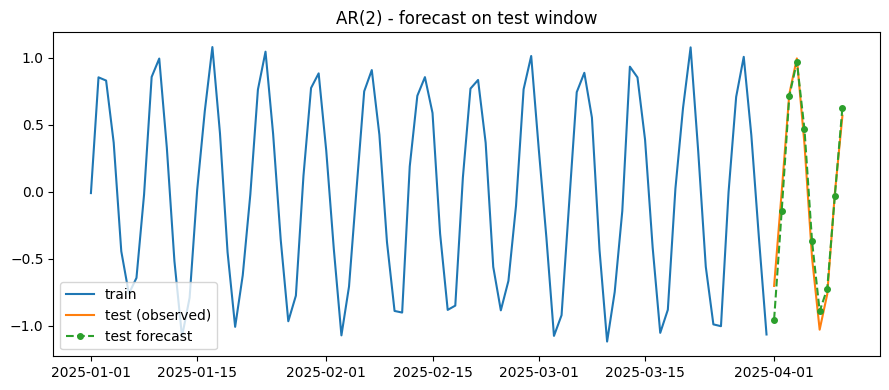

In [6]:
def make_ar_model_and_plot_with_validation(forecast_horizon: int, lag_order: int):
    y = pd.Series(ts_with_season, index=datetime_index, name="y")
    split_point = len(y) - forecast_horizon
    y_train = y.iloc[:split_point]
    y_test = y.iloc[split_point:]
    
    model = AutoReg(y_train, lags=lag_order, old_names=False)
    result = model.fit()
    
    y_test_pred_values = result.forecast(steps=forecast_horizon)
    
    y_test_forecast = pd.Series(y_test_pred_values, index=y_test.index, name="forecast")
    
    plt.figure(figsize=(9, 4))
    plt.plot(y_train.index, y_train.values, label="train")
    plt.plot(y_test.index, y_test.values, label="test (observed)")
    plt.plot(y_test_forecast.index, y_test_forecast.values, linestyle="--", marker="o", markersize=4, label="test forecast")
    plt.title(f"AR({lag_order}) - forecast on test window")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_test, y_test_forecast

forecast_horizon = 10
lag_order = 2
y_test, y_test_forecast = make_ar_model_and_plot_with_validation(forecast_horizon, lag_order)

## Метрики 

Классические регрессионные метрики

In [7]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


def symmetric_mean_absolute_percentage_error(actual, predicted):
    """ Function to calculate SMAPE metric """

    actual = np.array(actual)
    predicted = np.array(predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    non_zero = denominator != 0

    smape = np.zeros_like(actual, dtype=float)
    smape[non_zero] = np.abs(predicted[non_zero] - actual[non_zero]) / denominator[non_zero]
    return 100 * np.mean(smape)


mae_value = mean_absolute_error(y_test.values, y_test_forecast.values)
print(f"MAE {mae_value:.2f}")

smape_value = symmetric_mean_absolute_percentage_error(y_test.values, y_test_forecast.values)
print(f"SMAPE {smape_value:.2f}, %")

MAE 0.09
SMAPE 41.17, %


Главное, понимать специфику:

<img src="../data/how_can_we_quantify_similarity_between_time_series.png" alt="Time series dataset" width="800">

© [How can we quantify similarity between time series?](https://medium.com/gorillatech/how-can-we-quantify-similarity-between-time-series-ed1d0b633ca0)

## Валидация

Длина ряда - 100 элементов, а метрика посчитана на последних 10, что составляет всего 10%.
Что делать если хочется увеличить размер выборки до 20% или 30%.

### Подход 1. Увеличить горизонт прогнозирования

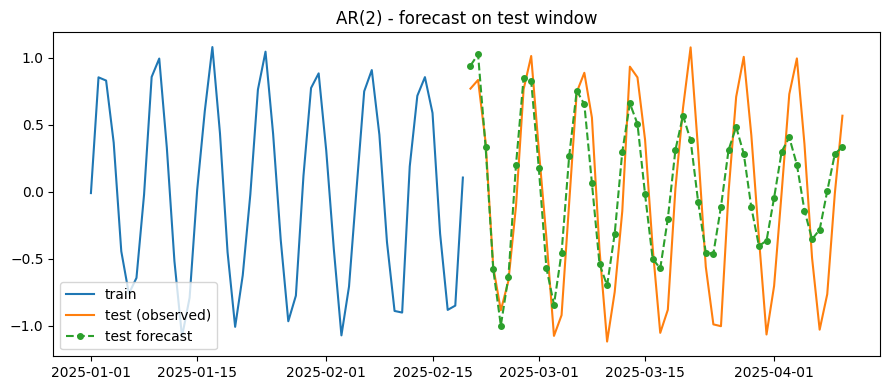

In [8]:
_, _ = make_ar_model_and_plot_with_validation(forecast_horizon*5, lag_order)

Но есть две проблемы: 

- Не все модели на временных рядах строят прогнозы рекурсивно как AR, то есть для таких forecast_horizon должен быть фиксирован 
- Поскольку авторегрессионные модели используют предсказания как предикторы для следующей итерации, неопределенность предсказаний накапливается 

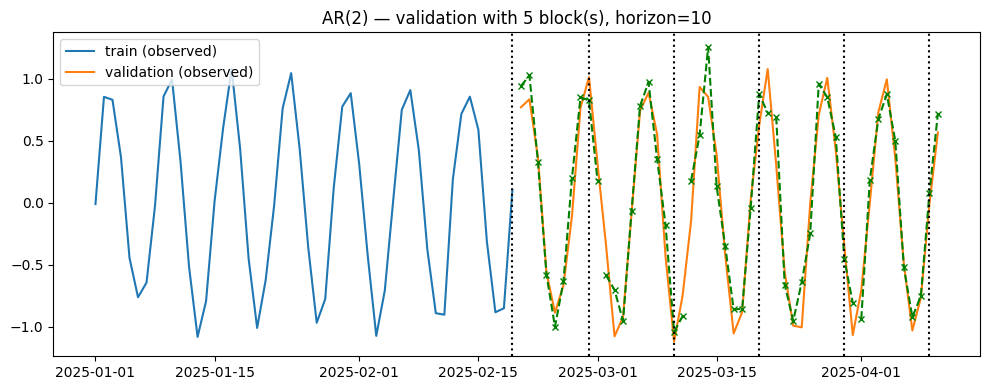

In [9]:
def make_ar_model_and_plot_with_validation_blocks(
    forecast_horizon: int,
    lag_order: int,
    validation_blocks: int
):
    y = pd.Series(ts_with_season, index=datetime_index, name="y")

    total_points = len(y)
    validation_length = validation_blocks * forecast_horizon
    train_end_index = total_points - validation_length

    # Split into train and validation tail
    y_train = y.iloc[:train_end_index]
    y_valid = y.iloc[train_end_index:]

    # Fit AR(lag_order) on training data
    model = AutoReg(y_train, lags=lag_order, old_names=False)
    result = model.fit()

    params = result.params
    intercept = float(params.get("const", 0.0))
    ar_coefs = [float(params.get(f"y.L{j}", 0.0)) for j in range(1, lag_order + 1)]

    block_forecasts = {}

    block1_start = train_end_index
    block1_end = train_end_index + forecast_horizon  # exclusive slice end
    block1_index = y.index[block1_start:block1_end]

    block1_values = result.forecast(steps=forecast_horizon)
    block_forecasts[1] = pd.Series(block1_values, index=block1_index, name="forecast_block_1")

    for b in range(2, validation_blocks + 1):
        start_idx = train_end_index + (b - 1) * forecast_horizon
        end_idx_exclusive = train_end_index + b * forecast_horizon
        block_index = y.index[start_idx:end_idx_exclusive]

        preds = []
        for t_pos in range(start_idx, end_idx_exclusive):
            y_hat = intercept
            for j in range(1, lag_order + 1):
                y_hat += ar_coefs[j - 1] * y.iloc[t_pos - j]
            preds.append(y_hat)

        block_forecasts[b] = pd.Series(preds, index=block_index, name=f"forecast_block_{b}")

    plt.figure(figsize=(10, 4))
    plt.plot(y_train.index, y_train.values, label="train (observed)")
    plt.plot(y_valid.index, y_valid.values, label="validation (observed)")

    for b, series_b in block_forecasts.items():
        style = "--"
        marker = "x"
        plt.plot(series_b.index, series_b.values, linestyle=style, marker=marker,
                 markersize=4, c="green")
        plt.axvline(series_b.index[-2], linestyle=":", c='black')
    plt.axvline(y_train.index[-1], linestyle=":", c='black')
    plt.title(f"AR({lag_order}) — validation with {validation_blocks} block(s), horizon={forecast_horizon}")
    plt.legend()
    plt.tight_layout()
    plt.show()

make_ar_model_and_plot_with_validation_blocks(forecast_horizon, lag_order, validation_blocks=5)

Подытожим про валидацию

<img src="../data/forecast_validation.gif" alt="Time series dataset" width="700">


Теперь вернемся к моделям


## MA (moving average, параметр q)

In [10]:
from ipywidgets import interact, IntSlider, fixed


def moving_average_forecast(series, window_size: int, forecast_horizon: int):
    values = np.asarray(series, dtype=float)
    history = values.copy()
    forecasts = []
    for _ in range(forecast_horizon):
        window = history[-window_size:] if history.size >= window_size else history
        next_value = float(window.mean())
        forecasts.append(next_value)
        history = np.append(history, next_value)
    return np.array(forecasts)

def make_ma_model_and_plot_with_validation(forecast_horizon: int, window_size: int, ts: np.array):
    """
    Train on the first len(y) - forecast_horizon points.
    Forecast exactly the test window length with a recursive moving average.
    Assumes `ts_with_season` and `datetime_index` exist in the outer scope.
    """
    y = pd.Series(ts, index=datetime_index, name="y")

    split_point = len(y) - forecast_horizon
    y_train = y.iloc[:split_point]
    y_test = y.iloc[split_point:]

    y_test_pred_values = moving_average_forecast(
        y_train.values, window_size=window_size, forecast_horizon=forecast_horizon
    )
    y_test_forecast = pd.Series(y_test_pred_values, index=y_test.index, name="forecast")

    plt.figure(figsize=(12, 4))
    plt.plot(y_train.index, y_train.values, label="train")
    # highlight the last `window_size` points used for the first MA prediction
    plt.scatter(y_train.index[-window_size:], y_train.values[-window_size:], c='green', s=100, marker='o', label="window")
    plt.plot(y_test.index, y_test.values, label="test (observed)")
    plt.plot(y_test_forecast.index, y_test_forecast.values,
             linestyle="--", marker="o", markersize=4, label="test forecast")
    plt.title(f"Moving Average (window={window_size}) - forecast on test window")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

interact(
    make_ma_model_and_plot_with_validation,
    window_size=IntSlider(value=3, min=2, max=10, step=1, description="window"),
    forecast_horizon=IntSlider(value=5, min=1, max=10, step=1, description="horizon"),
    ts=fixed(ts_with_season)
);

interactive(children=(IntSlider(value=5, description='horizon', max=10, min=1), IntSlider(value=3, description…

Если вам кажется что AR модель лучше (прогнозирует с меньшей ошибкой), то вам не кажется. 

Однако есть и для MA есть свои области применения

In [11]:
ts_with_season_and_shift = get_ts_with_season()
for i in range(85, 100):
    current_value = ts_with_season_and_shift[i]
    current_value = current_value + 10
    ts_with_season_and_shift[i] = current_value

    
interact(
    make_ma_model_and_plot_with_validation,
    window_size=IntSlider(value=3, min=2, max=10, step=1, description="window"),
    forecast_horizon=IntSlider(value=2, min=1, max=10, step=1, description="horizon"),
    ts=fixed(ts_with_season_and_shift)
);

interactive(children=(IntSlider(value=2, description='horizon', max=10, min=1), IntSlider(value=3, description…

## ARMA

In [12]:
from statsmodels.tsa.arima.model import ARIMA


def make_arma_statsmodels_and_plot_with_validation(
    forecast_horizon: int,
    ar_order: int,
    ma_order: int,
    vmin: int,
    vmax: int,
    ts: np.array,
):
    y = pd.Series(ts, index=datetime_index, name="y")

    split_point = len(y) - forecast_horizon
    y_train = y.iloc[:split_point]
    y_test = y.iloc[split_point:]

    trend = "c"
    model = ARIMA(endog=y_train, order=(ar_order, 0, ma_order), trend=trend,
                  enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()

    pred = result.get_forecast(steps=forecast_horizon)
    y_test_forecast = pd.Series(pred.predicted_mean, index=y_test.index, name="forecast")
    conf_intervals_df = pred.conf_int()
    conf_intervals_df.index = y_test.index

    mae = mean_absolute_error(y_test.values, y_test_forecast.values)

    plt.figure(figsize=(9, 4))
    plt.plot(y_train.index, y_train.values, label="train")
    plt.plot(y_test.index, y_test.values, label="test (observed)")
    plt.plot(y_test_forecast.index, y_test_forecast.values,
             linestyle="--", marker="o", markersize=4,
             label=f"forecast ARMA({ar_order},{ma_order})")
    plt.fill_between(y_test.index, conf_intervals_df.iloc[:, 0], conf_intervals_df.iloc[:, 1],
                     alpha=0.2, label="conf. interval")
    plt.title(f"ARMA({ar_order},{ma_order}) — forecast on test window | MAE={mae:.2f}")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.ylim(vmin, vmax)
    plt.tight_layout()
    plt.show()


interact(
    make_arma_statsmodels_and_plot_with_validation,
    forecast_horizon=IntSlider(value=10, min=1, max=30, step=1, description="horizon"),
    ar_order=IntSlider(value=2, min=0, max=3, step=1, description="ar_order"),
    ma_order=IntSlider(value=1, min=0, max=3, step=1, description="ma_order"),
    vmin=fixed(-2), vmax=fixed(2),
    ts=fixed(ts_with_season)
);

interactive(children=(IntSlider(value=10, description='horizon', max=30, min=1), IntSlider(value=2, descriptio…

In [5]:
trend = 0.1 * t
m = 7
eps = 0.1
# Amplitude of seasonal component increases over time
amplitude = np.linspace(0.5, 3.0, n)
seasonal_with_var = amplitude * np.sin(2 * np.pi * t / m)
ts_with_linear_trend_seasonality_and_variance = trend + seasonal_with_var + 0.1 * eps

# IMPORTANT NOTE - In this time series there is no noise component

In [15]:
interact(
    make_arma_statsmodels_and_plot_with_validation,
    forecast_horizon=IntSlider(value=10, min=1, max=30, step=1, description="horizon"),
    ar_order=IntSlider(value=2, min=0, max=3, step=1, description="ar_order"),
    ma_order=IntSlider(value=1, min=0, max=3, step=1, description="ma_order"),
    vmin=fixed(-2), vmax=fixed(16),
    ts=fixed(ts_with_linear_trend_seasonality_and_variance)
);

interactive(children=(IntSlider(value=10, description='horizon', max=30, min=1), IntSlider(value=2, descriptio…

## ARIMA

In [16]:
from statsmodels.tsa.arima.model import ARIMA


def make_arima_statsmodels_and_plot_with_validation(
    forecast_horizon: int,
    ar_order: int,
    ma_order: int,
    i: int,
    vmin: int,
    vmax: int,
    ts: np.array,
):
    y = pd.Series(ts, index=datetime_index, name="y")

    split_point = len(y) - forecast_horizon
    y_train = y.iloc[:split_point]
    y_test = y.iloc[split_point:]

    trend = "t"
    model = ARIMA(endog=y_train, order=(ar_order, i, ma_order), trend=trend,
                  enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()

    pred = result.get_forecast(steps=forecast_horizon)
    y_test_forecast = pd.Series(pred.predicted_mean, index=y_test.index, name="forecast")
    conf_intervals_df = pred.conf_int()
    conf_intervals_df.index = y_test.index

    # Compute MAE on the test window
    mae = float(np.mean(np.abs(y_test.values - y_test_forecast.values)))

    plt.figure(figsize=(9, 4))
    plt.plot(y_train.index, y_train.values, label="train")
    plt.plot(y_test.index, y_test.values, label="test (observed)")
    plt.plot(y_test_forecast.index, y_test_forecast.values,
             linestyle="--", marker="o", markersize=4,
             label=f"forecast ARMA({ar_order},{ma_order})")
    plt.fill_between(y_test.index, conf_intervals_df.iloc[:, 0], conf_intervals_df.iloc[:, 1],
                     alpha=0.2, label="conf. interval")
    plt.title(f"ARIMA({ar_order},{i},{ma_order}) — forecast on test window | MAE={mae:.2f}")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.ylim(vmin, vmax)
    plt.tight_layout()
    plt.show()


interact(
    make_arima_statsmodels_and_plot_with_validation,
    forecast_horizon=IntSlider(value=10, min=1, max=30, step=1, description="horizon"),
    ar_order=IntSlider(value=2, min=0, max=3, step=1, description="ar_order"),
    ma_order=IntSlider(value=1, min=0, max=3, step=1, description="ma_order"),
    i=IntSlider(value=1, min=0, max=1, step=1, description="i"),
    vmin=fixed(-2), vmax=fixed(16),
    ts=fixed(ts_with_linear_trend_seasonality_and_variance)
);

interactive(children=(IntSlider(value=10, description='horizon', max=30, min=1), IntSlider(value=2, descriptio…

## pmdarima

https://github.com/alkaline-ml/pmdarima

Прото-AutoML: оптимизация гиперпараметров

- MIT License
- `pip install pmdarima`. Устанавливается легко, но можно повозиться совместимостью Python/NumPy
- [Релиз 2.0.4 Oct 23, 2023](https://pypi.org/project/pmdarima/#history). Поддерживается
- Есть возможность распараллеливания вычислений
- Нет возможности включить произвольные пользовательские метрики
- "Всё или ничего": возможности остановить оптимизацию (и потом возобновить) нет
- Контроль времени оптимизации косвенный - через ограничение итераций и сужение пространства поиска

/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/pmdarima/compat/sklearn.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/li

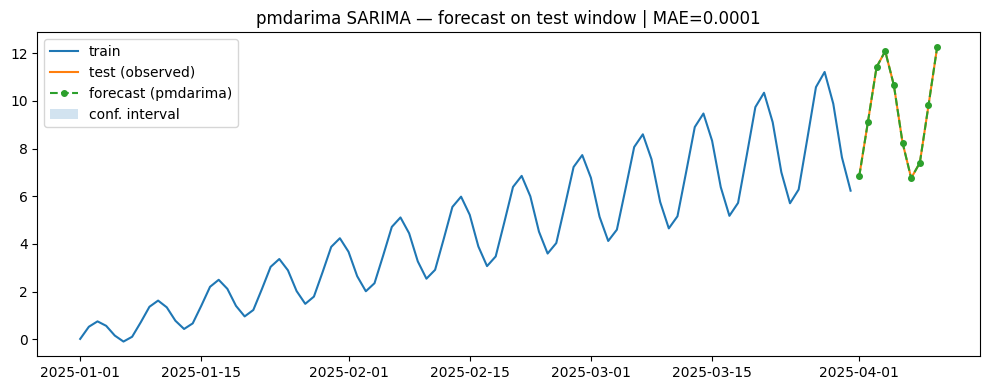

MAE on test window: 0.000092
Model saved & loaded from: sarima_pmdarima_model.joblib


In [16]:
from pmdarima import auto_arima
import joblib

forecast_horizon = 10
seasonal_period = 7
y = pd.Series(ts_with_linear_trend_seasonality_and_variance, index=datetime_index, name="y")

# Train/test split
split_point = len(y) - forecast_horizon
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

# Fit a seasonal ARIMA (SARIMA) via pmdarima.auto_arima
# Let auto_arima pick (p,d,q)(P,D,Q) with the given seasonal period m
model = auto_arima(
    y_train,
    seasonal=True,
    m=seasonal_period,
    stepwise=True,
    information_criterion="aicc",
    suppress_warnings=True,
    error_action="ignore",
    trace=False,
)

# Save the fitted model
model_path = "sarima_pmdarima_model.joblib"
joblib.dump(model, model_path)

# Load the model back and forecast on the test window ---
loaded_model = joblib.load(model_path)

# In case we need more data
# new_y — это новые фактические точки (array-like), появившиеся после обучения
# loaded_model.update(new_y)  
y_pred, conf_int = loaded_model.predict(n_periods=forecast_horizon, return_conf_int=True, alpha=0.05)

y_test_forecast = pd.Series(y_pred, index=y_test.index, name="forecast")
conf_intervals_df = pd.DataFrame(conf_int, columns=["lower", "upper"], index=y_test.index)

# Evaluate MAE on the test window
mae = mean_absolute_error(y_test.values, y_test_forecast.values)

plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train.values, label="train")
plt.plot(y_test.index, y_test.values, label="test (observed)")
plt.plot(
    y_test_forecast.index, y_test_forecast.values,
    linestyle="--", marker="o", markersize=4, label="forecast (pmdarima)"
)
plt.fill_between(
    y_test.index, conf_intervals_df["lower"], conf_intervals_df["upper"],
    alpha=0.2, label="conf. interval"
)
plt.title(f"pmdarima SARIMA — forecast on test window | MAE={mae:.4f}")
plt.legend()
plt.tight_layout()
plt.show()

## AutoTS

https://github.com/winedarksea/AutoTS

AutoML путем перебора: подбор моделей из [нескольких классов](https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html#id9)

и немнооого ансамблирования

- MIT License
- `pip install autots`. Устанваливается легко и непринужденно, 10 из 10
- [Релиз 0.6.21 Mar 5, 2025](https://pypi.org/project/autots/#history). Поддерживается
- Есть возможность распараллеливания вычислений
- Произвольную функцию метрики напрямую задать нельзя, но можно настраивать «Score» через `metric_weighting`
- Контроль времени оптимизации косвенный - через ограничение итераций и выбор списка моделей

In [19]:
from autots import AutoTS


forecast_horizon: int = 10
# "superfast" | "fast" | "default" | custom list
model_list: str = "superfast"
transformer_list: str = "superfast"
max_generations: int = 3
num_validations: int = 2
random_seed: int = 2025
export_path: str = "autots_best_model.json"

# 1 Data preparation
y = pd.Series(
    ts_with_linear_trend_seasonality_and_variance,
    index=datetime_index,
    name="y"
)
split_point = len(y) - forecast_horizon
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

# AutoTS
df_train_wide = pd.DataFrame({"y": y_train.values}, index=y_train.index)

# 2 Configure and fit AutoTS
autots_model = AutoTS(
    forecast_length=forecast_horizon,
    frequency="infer",
    prediction_interval=0.95,
    ensemble=None,
    model_list=model_list,
    transformer_list=transformer_list,
    max_generations=max_generations,
    num_validations=num_validations,
    validation_method="backwards",
    random_seed=random_seed,
    n_jobs="auto"
).fit(df_train_wide)

# 3 Predict exactly the test window
prediction = autots_model.predict(forecast_length=forecast_horizon)
forecast_df = prediction.forecast
lower_df = prediction.lower_forecast
upper_df = prediction.upper_forecast

y_test_forecast = pd.Series(forecast_df["y"].values, index=y_test.index, name="forecast")
mae_initial = mean_absolute_error(y_test.values, y_test_forecast.values)

# Export the single best model to a reusable file
autots_model.export_best_model(export_path)

Using 4 cpus for n_jobs.
Data frequency is: D, used frequency is: D
Model Number: 1 with model AverageValueNaive in generation 0 of 3
Model Number: 2 with model AverageValueNaive in generation 0 of 3
Model Number: 3 with model AverageValueNaive in generation 0 of 3
Model Number: 4 with model GLS in generation 0 of 3
Model Number: 5 with model GLS in generation 0 of 3
Model Number: 6 with model LastValueNaive in generation 0 of 3
Model Number: 7 with model LastValueNaive in generation 0 of 3
Model Number: 8 with model LastValueNaive in generation 0 of 3
Model Number: 9 with model LastValueNaive in generation 0 of 3
Model Number: 10 with model SeasonalNaive in generation 0 of 3
Model Number: 11 with model SeasonalNaive in generation 0 of 3
Model Number: 12 with model SeasonalNaive in generation 0 of 3
Model Number: 13 with model ConstantNaive in generation 0 of 3
Model Number: 14 with model SeasonalNaive in generation 0 of 3
Model Number: 15 with model SectionalMotif in generation 0 of 3

/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/models/basics.py:3647: RuntimeWarning: invalid value encountered in sqrt
  self.sigma = np.sqrt(sse / (n - p))


Model Number: 40 with model SeasonalityMotif in generation 0 of 3
Template Eval Error: ValueError('kth(=99) out of bounds (80)') in model 40 in generation 0: SeasonalityMotif
Model Number: 41 with model SeasonalityMotif in generation 0 of 3
Model Number: 42 with model BasicLinearModel in generation 0 of 3
Model Number: 43 with model LastValueNaive in generation 0 of 3
Model Number: 44 with model SeasonalityMotif in generation 0 of 3
Model Number: 45 with model SeasonalityMotif in generation 0 of 3
Model Number: 46 with model GLS in generation 0 of 3
Model Number: 47 with model AverageValueNaive in generation 0 of 3
Model Number: 48 with model ConstantNaive in generation 0 of 3
Model Number: 49 with model LastValueNaive in generation 0 of 3
Model Number: 50 with model GLS in generation 0 of 3
Model Number: 51 with model SeasonalityMotif in generation 0 of 3
Model Number: 52 with model BasicLinearModel in generation 0 of 3
Model Number: 53 with model GLS in generation 0 of 3
Model Number

/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'rolling_mean', 'transformations': {'0': 'ClipOutliers', '1': 'Detrend', '2': 'bkfilter', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 4, 'fillna': None}, '1': {'model': 'GLS', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {}, '3': {'rows': 4, 'lag': 84, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'max'}}}. fail_on_forecast_nan=True") in model 56 in generation 0: GLS
Model Number: 57 with model SeasonalNaive in generation 0 of 3
Model Number: 58 with model SectionalMotif in generation 0 of 3
Model Number: 59 with model SeasonalityMotif in generation 0 of 3
Model Number: 60 with model GLS in generation 0 of 3
Model Number: 61 with model SeasonalityMotif in generation 0 of 3
Model Number: 62 with model ConstantNaive in generation 0 of 3
Model Number: 63 with model SectionalMotif

/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 101 with model AverageValueNaive in generation 1 of 3
Model Number: 102 with model LastValueNaive in generation 1 of 3
Model Number: 103 with model BasicLinearModel in generation 1 of 3
New Generation: 2 of 3
Model Number: 104 with model SectionalMotif in generation 2 of 3
Model Number: 105 with model SectionalMotif in generation 2 of 3
Model Number: 106 with model BasicLinearModel in generation 2 of 3
Model Number: 107 with model BasicLinearModel in generation 2 of 3
Model Number: 108 with model SeasonalityMotif in generation 2 of 3
Model Number: 109 with model BasicLinearModel in generation 2 of 3
Model Number: 110 with model SeasonalNaive in generation 2 of 3
Model Number: 111 with model AverageValueNaive in generation 2 of 3
Model Number: 112 with model LastValueNaive in generation 2 of 3
Model Number: 113 with model SeasonalNaive in generation 2 of 3
Model Number: 114 with model BasicLinearModel in generation 2 of 3
Model Number: 115 with model LastValueNaive in gene

/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 134 with model SeasonalNaive in generation 2 of 3
Model Number: 135 with model SeasonalNaive in generation 2 of 3
Model Number: 136 with model SeasonalityMotif in generation 2 of 3
Model Number: 137 with model LastValueNaive in generation 2 of 3
Model Number: 138 with model SectionalMotif in generation 2 of 3
Model Number: 139 with model GLS in generation 2 of 3
Model Number: 140 with model ConstantNaive in generation 2 of 3
Model Number: 141 with model GLS in generation 2 of 3
Model Number: 142 with model LastValueNaive in generation 2 of 3
Model Number: 143 with model AverageValueNaive in generation 2 of 3
New Generation: 3 of 3
Model Number: 144 with model SectionalMotif in generation 3 of 3
Model Number: 145 with model GLS in generation 3 of 3
Model Number: 146 with model SeasonalityMotif in generation 3 of 3
Model Number: 147 with model SeasonalNaive in generation 3 of 3


/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 148 with model GLS in generation 3 of 3
Model Number: 149 with model SeasonalNaive in generation 3 of 3
Model Number: 150 with model AverageValueNaive in generation 3 of 3
Model Number: 151 with model SeasonalNaive in generation 3 of 3
Model Number: 152 with model SectionalMotif in generation 3 of 3
Model Number: 153 with model AverageValueNaive in generation 3 of 3
Model Number: 154 with model ConstantNaive in generation 3 of 3
Model Number: 155 with model BasicLinearModel in generation 3 of 3
Model Number: 156 with model SeasonalityMotif in generation 3 of 3
Model Number: 157 with model LastValueNaive in generation 3 of 3
Model Number: 158 with model BasicLinearModel in generation 3 of 3
Template Eval Error: ValueError('matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 80 is different from 1345)') in model 158 in generation 3: BasicLinearModel
Model Number: 159 with model SeasonalNaive in generation 3 of 3

/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 161 with model SeasonalNaive in generation 3 of 3
Model Number: 162 with model SeasonalityMotif in generation 3 of 3
Model Number: 163 with model AverageValueNaive in generation 3 of 3
Model Number: 164 with model BasicLinearModel in generation 3 of 3
Model Number: 165 with model BasicLinearModel in generation 3 of 3
Model Number: 166 with model SeasonalityMotif in generation 3 of 3
Model Number: 167 with model SeasonalityMotif in generation 3 of 3
Model Number: 168 with model SeasonalityMotif in generation 3 of 3
Model Number: 169 with model SeasonalityMotif in generation 3 of 3
Model Number: 170 with model SectionalMotif in generation 3 of 3
Model Number: 171 with model SeasonalNaive in generation 3 of 3
Model Number: 172 with model SectionalMotif in generation 3 of 3
Model Number: 173 with model AverageValueNaive in generation 3 of 3
Model Number: 174 with model LastValueNaive in generation 3 of 3
Model Number: 175 with model SeasonalityMotif in generation 3 of 3
Model

/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/models/basics.py:3647: RuntimeWarning: divide by zero encountered in divide
  self.sigma = np.sqrt(sse / (n - p))
/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/evaluator/auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
/home/dreamlone/.cache/pypoetry/virtualenvs/ts-processing-46XY6VDG-py3.10/lib/python3.10/site-packages/autots/evaluator/auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitl

Using 3 cpus for n_jobs.
Data frequency is: D, used frequency is: D


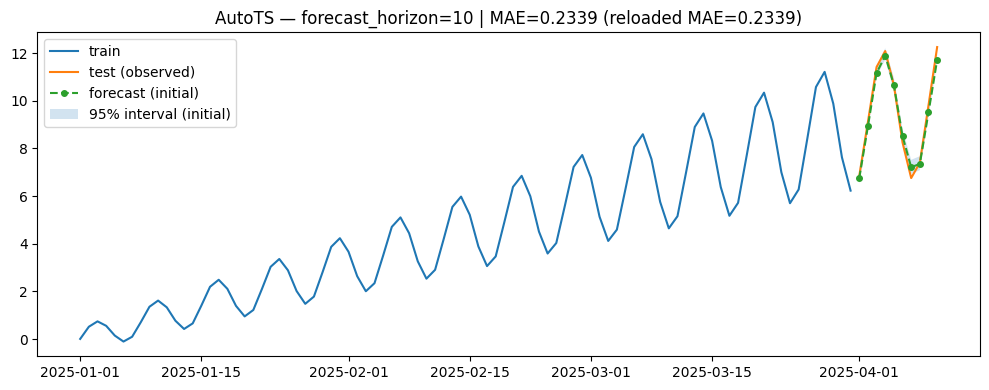

Saved best model to: autots_best_model.json
MAE initial:  0.23386
MAE reloaded: 0.23386
Best model name: SeasonalityMotif


In [25]:
# 5 Create a fresh AutoTS object, import the best model, attach data, and predict again
reloaded = AutoTS(forecast_length=forecast_horizon, frequency="infer", prediction_interval=0.95)
reloaded = reloaded.import_best_model(export_path) 

# Attach training data or new data from where to start a new forecast
reloaded = reloaded.fit_data(df_train_wide)
prediction_reloaded = reloaded.predict(forecast_length=forecast_horizon)

forecast_df_reloaded = prediction_reloaded.forecast
y_test_forecast_reloaded = pd.Series(forecast_df_reloaded["y"].values, index=y_test.index, name="forecast")
mae_reloaded = mean_absolute_error(y_test.values, y_test_forecast_reloaded.values)

# 6) Plot train, test, and forecast (with 95% intervals if available)
plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train.values, label="train")
plt.plot(y_test.index, y_test.values, label="test (observed)")
plt.plot(y_test_forecast.index, y_test_forecast.values,
         linestyle="--", marker="o", markersize=4, label="forecast (initial)")
if lower_df is not None and upper_df is not None:
    plt.fill_between(
        y_test.index, lower_df["y"].values, upper_df["y"].values,
        alpha=0.2, label="95% interval (initial)"
    )
plt.title(f"AutoTS — forecast_horizon={forecast_horizon} | MAE={mae_initial:.4f} "
          f"(reloaded MAE={mae_reloaded:.4f})")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

print(f"Saved best model to: {export_path}")
print(f"MAE initial:  {mae_initial:.5f}")
print(f"MAE reloaded: {mae_reloaded:.5f}")
name = autots_model.best_model_name
print(f"Best model name: {name}")

## FEDOT

https://github.com/aimclub/FEDOT

"Композитный" AutoML: генерация сложных многоуровневых графов с предобработками и моделями

- BSD 3-Clause License
- `pip install fedot`. Даже проще, чем AutoTS, 11 из 10
- [Релиз 0.7.5 Mar 10, 2025](https://pypi.org/project/fedot/#history). Поддерживается
- Есть возможность распараллеливания вычислений
- Есть возможность задавать произвольные пользовательские метрики
- Контроль времени оптимизации

<img src="../data/fedot_linear_pipeline.png" alt="FEDOT linear pipeline" width="900">


In [36]:
from fedot.api.main import Fedot
from fedot.core.repository.tasks import TsForecastingParams

forecast_horizon = 10
y = pd.Series(ts_with_linear_trend_seasonality_and_variance, index=datetime_index, name="y")

split_point = len(y) - forecast_horizon
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

model = Fedot(
    problem="ts_forecasting",
    task_params=TsForecastingParams(forecast_length=forecast_horizon),
    preset="fast_train",
    timeout=1
)

pipeline = model.fit(features=y_train.values)

2025-10-15 00:56:14,369 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:14,399 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 7
2025-10-15 00:56:14,416 - ApiComposer - Initial pipeline was fitted in 0.0 sec.
2025-10-15 00:56:14,417 - ApiComposer - Taking into account n_folds=3, estimated fit time for initial assumption is 0.1 sec.
2025-10-15 00:56:14,418 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:14,419 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:14,420 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Pleas

Generations:   0%|                                                                                                                                                                              | 0/10000 [00:00<?, ?gen/s]

2025-10-15 00:56:14,508 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 7
2025-10-15 00:56:14,509 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 7
2025-10-15 00:56:14,675 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-10-15 00:56:14,691 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:14,692 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:14,693 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:14,694 - Extra dependencies for time series

Generations:   0%|                                                                                                                                                                   | 1/10000 [00:09<25:32:48,  9.20s/gen]

2025-10-15 00:56:23,730 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:23,732 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:23,733 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:23,734 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:23,745 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:23,746 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please ins

Generations:   0%|                                                                                                                                                                   | 2/10000 [00:10<12:46:49,  4.60s/gen]

2025-10-15 00:56:25,156 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:25,157 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:25,159 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:25,160 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:25,176 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:25,178 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please ins

Generations:   0%|                                                                                                                                                                   | 3/10000 [00:17<15:59:57,  5.76s/gen]

2025-10-15 00:56:32,288 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:32,290 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:32,291 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:32,292 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:32,312 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:32,313 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please ins

Generations:   0%|                                                                                                                                                                   | 4/10000 [00:23<15:50:17,  5.70s/gen]

2025-10-15 00:56:37,886 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:37,887 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:37,888 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:37,890 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:37,905 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:37,907 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please ins

Generations:   0%|                                                                                                                                                                   | 5/10000 [00:27<14:35:02,  5.25s/gen]

2025-10-15 00:56:42,346 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:42,348 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:42,349 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:42,350 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:42,362 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-15 00:56:42,364 - Extra dependencies for time series forecasting are not installed. It can infuence the performance. Please ins

Generations:   0%|                                                                                                                                                                   | 6/10000 [00:33<15:16:01,  5.50s/gen]

2025-10-15 00:56:48,303 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                                                                                                                   | 6/10000 [00:33<15:38:24,  5.63s/gen]

2025-10-15 00:56:48,310 - ApiComposer - Hyperparameters tuning started with 0 min. timeout
2025-10-15 00:56:48,370 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [linear, ridge, lagged]}
linear - {}
ridge - {}
lagged - {'window_size': 7} 
Initial metric: [0.0]
  0%|                                                                                                                                                                           | 0/100000 [00:00<?, ?trial/s, best loss=?]

  0%|▍                                                                                                                                          | 335/100000 [00:26<2:08:58, 12.88trial/s, best loss: 8.96349898760502e-15]
2025-10-15 00:57:14,444 - SimultaneousTuner - Final graph: {'depth': 3, 'length': 3, 'nodes': [linear, ridge, lagged]}
linear - {}
ridge - {}
lagged - {'window_size': 7}
2025-10-15 00:57:14,445 - SimultaneousTuner - Final metric: 0.000
2025-10-15 00:57:14,448 - ApiComposer - Hyperparameters tuning finished
2025-10-15 00:57:14,575 - ApiComposer - Model generation finished
2025-10-15 00:57:14,591 - FEDOT logger - Final pipeline was fitted
2025-10-15 00:57:14,592 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [linear, ridge, lagged]}
linear - {}
ridge - {}
lagged - {'window_size': 7}


MAE on test window: 0.000000


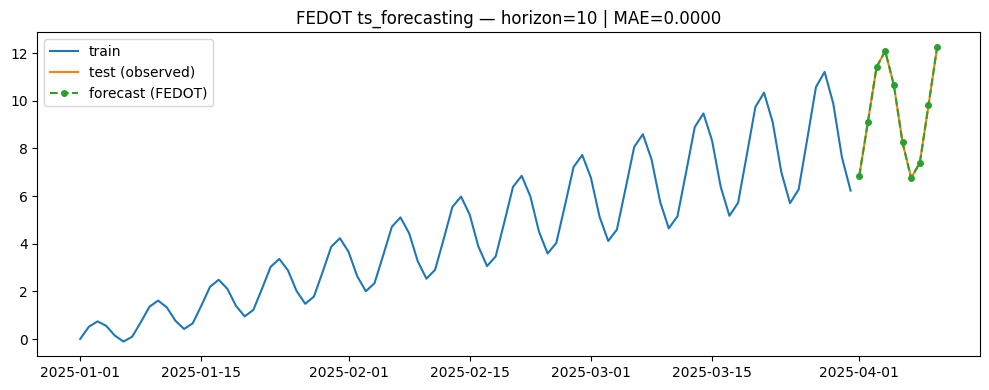

In [34]:
# --- Forecast exactly the test window ---
# For ts_forecasting, predict(features=history) returns next `forecast_length` points
y_pred = model.forecast(y_train.values)
y_test_forecast = pd.Series(y_pred, index=y_test.index, name="forecast")

# --- Evaluate MAE ---
mae = float(np.mean(np.abs(y_test.values - y_test_forecast.values)))
print(f"MAE on test window: {mae:.6f}")

# --- Plot train, test, and forecast ---
plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train.values, label="train")
plt.plot(y_test.index, y_test.values, label="test (observed)")
plt.plot(y_test_forecast.index, y_test_forecast.values,
         linestyle="--", marker="o", markersize=4, label="forecast (FEDOT)")
plt.title(f"FEDOT ts_forecasting — horizon={forecast_horizon} | MAE={mae:.4f}")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

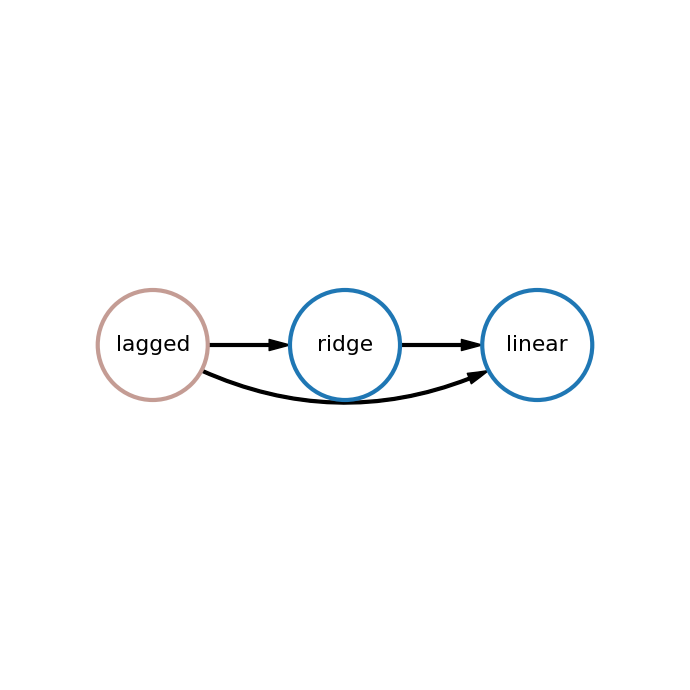

In [37]:
pipeline.show()

И немного про особенности внутренней реализации, например

<img src="../data/fedot_decomposition.png" alt="FEDOT decomposition" width="700">

И пожалуйста, посмотрите самостоятельно какие AutoML фреймворки существуют для решения задачи классификации временных рядов 

- Fedot.Industrial
- EvalML

И если вы заинтересовались темой автоматического прогнозирования временных рядов, то можете почитать эти статьи на хабре: 

- [Что делать, если твой временной ряд растёт вширь](https://habr.com/ru/articles/696336/)
- [Прогнозирование временных рядов с помощью AutoML](https://habr.com/ru/articles/559796/)